#LAB 3: Faster RCNN

<h4><div style="text-align: right"> Due date: 15:00 Nov 11, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>


### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).
- Download the dataset using the following code line;
wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000266/data/data.tar.gz

- For more information, please refer (https://stages.ai/competitions/325/data/overview)
> Copyright: CC BY 2.0

### dataset
    ├── train.json
    ├── test.json
    ├── train
    └── test

<h2><span style="color:blue">[201924451] [김태훈]</span> </h2>

In [1]:
! tar -zxf data.tar.gz

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # Arrange GPU devices
os.environ["CUDA_VISIBLE_DEVICES"]= "3" # Set the GPU 2 to use

In [2]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-08 15:55:35.054990


# Library Import

In [3]:
!pip install albumentations==1.3.1

In [4]:
# 권장 환경: python==3.7.13, pytorch==1.13.1, torchvision==0.14.1, albumentations==1.3.1, torchnet==0.0.4

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
# !pip install visdom

In [7]:
import os
import six
from collections import namedtuple

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.models import vgg16
from torchvision.ops import RoIPool
from torchvision.ops import nms

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils import data as data_

from torchnet.meter import ConfusionMeter, AverageValueMeter

# Util Functions

In [8]:
def loc2bbox(src_bbox, loc):
    """
    Decodes bouding boxes from bounding box offsets and scales.

    Args:
        src_bbox: A coordinates of bounding boxes.
            These coordinates are (p_ymin, p_xmin, p_ymax, p_xmax).
        loc: An array with offsets and scales.
            The shapes of 'src_bbox' and 'loc' should be same.
            This contains values: (t_y, t_x, t_h, t_w).
    Returns: Decoded bounding box coordinates.
    """

    if src_bbox.shape[0] == 0:
        return np.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)
    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox


def bbox2loc(src_bbox, dst_bbox):
    """
    Encodes the source and the destination bouding boxes to "loc".

    The offsets and scales t_y, t_x, t_h, t_w can be computed by the following formulas
    t_y = (g_y - p_y) / p_h
    t_x = (g_x - p_x) / p_w
    t_h = log(g_h / p_h)
    t_w = log(g_w / p_W)

    Args:
        src_bbox: These coordinates are (p_ymin, p_xmin, p_ymax, p_xmax).
        dst_bbox: These coordinates are (g_ymin, g_xmin, g_ymax, g_xmax).

    Returns:
        Bounding box offsets and scales from src_bbox to dst_bbox.
        The second axis contains four values (t_y, t_x, t_h, t_w).
    """

    # x_min, y_min, x_max, y_max
    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    # x_min, y_min, x_max, y_max
    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width

    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc

In [9]:
def normal_init(m, mean, stddev, truncated=False):
    """
    weight initialization
    """
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


def get_inside_index(anchor, H, W):
    # Calc indicies of anchors which are located completely inside of the image
    # whose size is speficied.
    index_inside = np.where(
        (anchor[:, 0] >= 0) &
        (anchor[:, 1] >= 0) &
        (anchor[:, 2] <= H) &
        (anchor[:, 3] <= W)
    )[0]
    return index_inside


def unmap(data, count, index, fill=0):
    # Unmap a subset of item (data) back to the original set of items (of size count)
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
    return ret

In [10]:
def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()

def totensor(data, cuda = True):
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    if isinstance(data, torch.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor

def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, torch.Tensor):
        return data.item()

# Main

### Hyper parameters

In [11]:
epochs=14
learning_rate = 1e-3
lr_decay = 0.1
weight_decay = 0.0005
# use dropout in RoIHead
use_drop = False

rpn_sigma = 3.     # sigma for l1_smooth_loss (RPN loss)
roi_sigma = 1.     # sigma for l1_smooth_loss (ROI loss)

# 데이터 경로
data_dir = './dataset'
# train시 checkpoint 경로
train_load_path =None
# inference시 체크포인트 경로
inf_load_path = './checkpoints/faster_rcnn_scratch_checkpoints.pth'

### Dataset loader

#### 1. TrainCustom class

In [12]:
# TrainDataset
class TrainCustom(Dataset):
    def __init__(self, annotation, data_dir, transforms = False):
        """
        Args:
            annotation: annotation 파일 위치
            data_dir: data가 존재하는 폴더 경로
            transforms : transform 여부
        """

        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.transforms = transforms

    def __getitem__(self, index: int):

        # 이미지 아이디 가져오기
        image_id = self.coco.getImgIds(imgIds=index)

        # 이미지 정보 가져오기
        image_info = self.coco.loadImgs(image_id)[0]

        # 이미지 로드
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # 어노테이션 파일 로드
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # 박스 가져오기
        boxes = np.array([x['bbox'] for x in anns])

        # boxes (x_min, y_min, x_max, y_max) 꼴로 변환
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # 레이블 가져오기
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # transform 함수 정의
        if self.transforms :
            scale = 1.0  # resize scale
            H, W, _ = image.shape
            resize_H = int(scale * H)
            resize_W = int(scale * W)
            transforms = get_train_transform(resize_H, resize_W)
        else :
            scale = 1.0
            transforms = no_transform()

        # transform
        sample = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
        }
        sample = transforms(**sample)
        image = sample['image']
        bboxes = torch.tensor(sample['bboxes'], dtype=torch.float32)
        boxes = torch.tensor(sample['bboxes'], dtype=torch.float32)

        # bboxes (x_min, y_min, x_max, y_max) -> boxes (y_min, x_min, y_max, x_max)
        boxes[:, 0] = bboxes[:, 1]
        boxes[:, 1] = bboxes[:, 0]
        boxes[:, 2] = bboxes[:, 3]
        boxes[:, 3] = bboxes[:, 2]

        return image, boxes, labels, scale

    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [13]:
# Test Dataset
class TestCustom(Dataset):
    def __init__(self, annotation, data_dir):
        """
        Args:
            annotation: annotation 파일 위치
            data_dir: data가 존재하는 폴더 경로
        """

        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)

    def __getitem__(self, index: int):

        # 이미지 아이디 가져오기
        image_id = self.coco.getImgIds(imgIds=index)

        # 이미지 정보 가져오기
        image_info = self.coco.loadImgs(image_id)[0]

        # 이미지 로드
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image, dtype = torch.float).permute(2,0,1)

        return image, image.shape[1:]

    def __len__(self) -> int:
        return len(self.coco.getImgIds())

#### 2. Transform

In [14]:
# Train dataset transform
def get_train_transform(h, w):
    return A.Compose([
        A.Resize(height = h, width = w),
        A.Flip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # add
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.5), # add
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# No transform
def no_transform():
    return A.Compose([
        ToTensorV2(p=1.0) # format for pytorch tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### RPN (Region Proposal Network)


#### 1. Anchor box generator

👉 mission1. anchor box 좌표값 생성
1. 중점 만들기 (base_size의 절반)


2. 하나의 중점당 ratio와 anchor scales에 따라 9개의 anchor box의 좌표값 만들기\
    anchor box의 좌표값 : (y_min, x_min, y_max, x_max)


In [15]:
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    """
    Args:
        ratios: 비율
        anchor_scales: 스케일
    Returns: basic anchor boxes, shape=(R, 4)
        R: len(ratio) * len(anchor_scales) = anchor 개수 = 9
        4: anchor box 좌표 값
    """
    ### YOUR CODE HERE
    ### ANSWER HERE ###
    # 구현해야 할 변수 : px, py
      # px
      # py
    py = base_size / 2.0
    px = base_size / 2.0

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32) # anchor_box

    for i in six.moves.range(len(ratios)):
        for j in six.moves.range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            # offset of anchor box

            ### YOUR CODE HERE
            ### ANSWER HERE ###
            # 구현해야 할 변수 : anchor_base
            # anchor_base[index, 0]
            # anchor_base[index, 1]
            # anchor_base[index, 2]
            # anchor_base[index, 3]
            anchor_base[index, 0] = py - h / 2.0
            anchor_base[index, 1] = px - w / 2.0
            anchor_base[index, 2] = py + h / 2.0
            anchor_base[index, 3] = px + w / 2.0

    return anchor_base # (9,4)

#### 2. ProposalCreator
RPN에서 구한 rpn_loc와 anchor을 통해서 Region of Interest(RoI)를 생성\
RoI 개수 줄이기 위해서 미리 정해둔 크기(min_size)에 맞는 roi들 중 NMS를 통해 최종 RoI 반환 (train 시 2000개)

In [16]:
class ProposalCreator:
    def __init__(self, parent_model,
                 nms_thresh=0.7, # nms threshold
                 n_train_pre_nms=12000, # train시 nms 전 roi 개수
                 n_train_post_nms=2000, # train시 nms 후 roi 개수
                 n_test_pre_nms=6000,   # test시 nms 전 roi 개수
                 n_test_post_nms=300,   # test시 nms 후 roi 개수
                 min_size=16
                 ):
        self.parent_model = parent_model
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score, anchor, img_size, scale=1.):
        if self.parent_model.training: # train중일 때
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else: # test중일 때
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # anchor의 좌표값과 predicted bounding bounding box offset(y,x,h,w)를 통해
        # bounding box 좌표값(y_min, x_min, y_max, x_max) 생성
        roi = loc2bbox(anchor, loc)

        # Clip predicted boxes to image.
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

        # min_size 보다 작은 box들은 제거
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN
        order = score.ravel().argsort()[::-1]
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]
        score = score[order]

        # nms 적용
        keep = nms(
            torch.from_numpy(roi).cuda(),
            torch.from_numpy(score).cuda(),
            self.nms_thresh)
        if n_post_nms > 0:
            keep = keep[:n_post_nms]
        roi = roi[keep.cpu().numpy()]

        return roi

#### 3. region proposal network

VGG16 통과한 feature map으로부터 region proposal들 생성

👉 mission2. Region Proposal Network
 **tensor shape은 모두 1024x1024 이미지 기준입니다.**
1. backbone에서 나온 feature map에 3x3 conv 연산을 적용하여 중간 feature map 생성 \
    input: x (torch.Size([1, 512, 64, 64]))\
    output: middle (torch.Size([1, 512, 64, 64]))
    
    
2. middle(중간 feature map)에 1x1 conv 연산을 적용하여 9x4(anchor box의 수 x bounding box 좌표값)개의 channel을 가지는 feature map 생성\
    input: middle (torch.Size([1, 512, 64, 64]))\
    output: rpn_locs (torch.Size([1, 36, 64, 64]))
    
    
3. middle(중간 feature map)에 1x1 conv 연산을 적용하여 9x2(anchor box의 수 x object 여부)개의 channel을 가지는 feature map 생성\
    input: middle (torch.Size([1, 512, 64, 64]))\
    output: rpn_locs (torch.Size([1, 18, 64, 64]))
    
    
4. Proposal Creator 함수를 사용하여 roi 생성

In [28]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32], feat_stride=16, proposal_creator_params=dict(),):

        super(RegionProposalNetwork, self).__init__()

        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios) # 9개의 anchorbox 생성
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params) # proposal_creator_params : 해당 네트워크가 training인지 testing인지 알려준다.
        n_anchor = self.anchor_base.shape[0] # anchor 개수
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)  # 9*2
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)   # 9*4
        normal_init(self.conv1, 0, 0.01) # weight initalizer
        normal_init(self.score, 0, 0.01) # weight initalizer
        normal_init(self.loc, 0, 0.01)   # weight initalizer

    def forward(self, x, img_size, scale=1.):
        # x(feature map)
        n, _, hh, ww = x.shape

        # 전체 (h*w*9)개 anchor의 좌표값 # anchor_base:(9, 4)
        anchor = _enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, hh, ww)
        n_anchor = anchor.shape[0] // (hh * ww) # anchor 개수

        ### YOUR CODE HERE
        ### ANSWER HERE ###
        middle = F.relu(self.conv1(x))

        # predicted bounding box offset
        ### YOUR CODE HERE
        ### ANSWER HERE ###
        rpn_locs = self.loc(middle)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)

        # predicted scores for anchor (foreground or background)
        ### YOUR CODE HERE
        ### ANSWER HERE ###
        rpn_scores = self.score(middle)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()

        # scores for foreground
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)

        rpn_scores = rpn_scores.view(n, -1, 2)

        # proposal생성 (ProposalCreator)
        rois = list()        # proposal의 좌표값이 있는 bounding box array
        roi_indices = list() # roi에 해당하는 image 인덱스
        for i in range(n):
            ### YOUR CODE HERE
            ### ANSWER HERE ###
            #proposal layer call param: (self, loc, score, anchor, img_size, scale=1.):
            roi = self.proposal_layer(rpn_locs[i].detach().cpu().numpy(),rpn_fg_scores[i].detach().cpu().numpy(),anchor, img_size, scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)
        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)

        return rpn_locs, rpn_scores, rois, roi_indices, anchor


def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    # anchor_base는 하나의 pixel에 9개 종류의 anchor box를 나타냄
    # 이것을 enumerate시켜 전체 이미지의 pixel에 각각 9개의 anchor box를 가지게 함
    # 32x32 feature map에서는 32x32x9=9216개의 anchor box가짐

    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor # (9216, 4)


### Feature extractor(VGG)


In [29]:
def decom_vgg16():
    # the 30th layer of features is relu of conv5_3
    model = vgg16(pretrained=True)

    features = list(model.features)[:30]
    classifier = model.classifier

    classifier = list(classifier)
    del classifier[6]
    if not use_drop:
        del classifier[5]
        del classifier[2]
    classifier = nn.Sequential(*classifier)

    # freeze top4 conv
    for layer in features[:10]:
        for p in layer.parameters():
            p.requires_grad = False

    return nn.Sequential(*features), classifier

### Faster R-CNN head

RoI pool 후에 classifier, regressor 통과

In [30]:
class VGG16RoIHead(nn.Module):
    """
    Faster R-CNN head
    RoI pool 후에 classifier, regressior 통과
    """

    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4) # bounding box regressor
        self.score = nn.Linear(4096, n_class) # Classifier

        normal_init(self.cls_loc, 0, 0.001)  # weight initialize
        normal_init(self.score, 0, 0.01)     # weight initialize

        self.n_class = n_class # 배경 포함한 class 수
        self.roi_size = roi_size # RoI-pooling 후 feature map의  높이, 너비
        self.spatial_scale = spatial_scale # roi resize scale
        self.roi = RoIPool( (self.roi_size, self.roi_size),self.spatial_scale)

    def forward(self, x, rois, roi_indices):
        # in case roi_indices is  ndarray
        roi_indices = totensor(roi_indices).float()
        rois = totensor(rois).float()
        indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
        # NOTE: important: yx->xy
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
        indices_and_rois =  xy_indices_and_rois.contiguous()

        # 각 이미지 roi pooling
        pool = self.roi(x, indices_and_rois)
        # flatten
        pool = pool.view(pool.size(0), -1)
        # fully connected
        fc7 = self.classifier(pool)
        # regression
        roi_cls_locs = self.cls_loc(fc7)
        # softmax
        roi_scores = self.score(fc7)


        return roi_cls_locs, roi_scores

### Faster R-CNN
Feature Extraction : image로부터 feature map 생성\
Region Proposal Networks : Region of Interest 생성\
Localization and Classification Head : RoI에 해당하는 feature map을 최종 detect

In [31]:
def nograd(f):
    def new_f(*args, **kwargs):
        with torch.no_grad():
            return f(*args, **kwargs)
    return new_f

class FasterRCNN(nn.Module):
    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor  # extractor : vgg
        self.rpn = rpn              # rpn : region proposal network
        self.head = head            # head : RoiHead

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset()

    @property
    def n_class(self): # 최종 class 개수 (배경 포함)
        return self.head.n_class

    # predict 시 사용하는 forward
    # train 시 FasterRCNNTrainer을 사용하여 FasterRcnn에 있는 extractor, rpn, head를 모듈별로 불러와서 forward
    def forward(self, x, scale=1.):
        img_size = x.shape[2:]

        h = self.extractor(x) # extractor 통과
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.rpn(h, img_size, scale) # rpn 통과
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices) # head 통과
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self): # prediction 과정 쓰이는 threshold 정의
        self.nms_thresh = 0.3
        self.score_thresh = 0.05

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()

        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            keep = nms(cls_bbox_l, prob_l,self.nms_thresh)
            bbox.append(cls_bbox_l[keep].cpu().numpy())
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep].cpu().numpy())

        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    @nograd
    def predict(self, imgs,sizes=None):
        """
        이미지에서 객체 검출
        Input : images
        Output : bboxes, labels, scores
        """
        self.eval()
        prepared_imgs = imgs

        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale) # self = FasterRCNN
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = torch.Tensor(self.loc_normalize_mean).cuda(). repeat(self.n_class)[None]
            std = torch.Tensor(self.loc_normalize_std).cuda(). repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(tonumpy(roi).reshape((-1, 4)),tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = (F.softmax(totensor(roi_score), dim=1))

            bbox, label, score = self._suppress(cls_bbox, prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset()
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        '''
        Optimizer 선언
        '''
        lr = learning_rate
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': weight_decay}]
        self.optimizer = torch.optim.SGD(params, momentum=0.9)
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer


### Faster R-CNN 생성
Extractor(VGG) + RPN + Head 합치기

In [32]:
class FasterRCNNVGG16(FasterRCNN):

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self, n_fg_class=10, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32] ): # n_fg_class : 배경포함 하지 않은 class 개수
        extractor, classifier = decom_vgg16()

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )
        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )


### Trainer

#### 0. util 함수 정의
bounding box IoU

In [33]:
def bbox_iou(bbox_a, bbox_b):
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError

    #bbox_a 1개와 bbox_b k개를 비교해야하므로 None을 이용해서 차원을 늘려서 연산한다.
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

#### 1. Anchor Target Creator
Anchor box에 해당하는 ground truth bounding box match\
Region Proposal Network loss 구할 때 ground truth로 사용

In [34]:
class AnchorTargetCreator(object):

    def __init__(self,
                 n_sample=256,
                 pos_iou_thresh=0.7, neg_iou_thresh=0.3,
                 pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):

        img_H, img_W = img_size

        n_anchor = len(anchor) # 9216
        inside_index = get_inside_index(anchor, img_H, img_W) # (2272,)
        anchor = anchor[inside_index] # (2272, 4)
        argmax_ious, label = self._create_label(
            inside_index, anchor, bbox)

        # compute bounding box regression targets
        loc = bbox2loc(anchor, bbox[argmax_ious]) # (2272, 4)

        # map up to original set of anchors
        label = unmap(label, n_anchor, inside_index, fill=-1) # (9216,)
        loc = unmap(loc, n_anchor, inside_index, fill=0) # (9216, 4)

        return loc, label

    def _create_label(self, inside_index, anchor, bbox):
        # label) 1 :positive, 0 : negative, -1 : dont care
        label = np.empty((len(inside_index),), dtype=np.int32)
        label.fill(-1)

        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox, inside_index)

        label[max_ious < self.neg_iou_thresh] = 0 # 0.3

        # 가장 iou가 큰 것은 positive label
        label[gt_argmax_ious] = 1

        # positive label
        label[max_ious >= self.pos_iou_thresh] = 1 # 0.7

        # subsample positive labels if we have too many
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(
                pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # subsample negative labels if we have too many
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(
                neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label

    def _calc_ious(self, anchor, bbox, inside_index):
        # ious between the anchors and the gt boxes
        ious = bbox_iou(anchor, bbox)
        argmax_ious = ious.argmax(axis=1)
        max_ious = ious[np.arange(len(inside_index)), argmax_ious]
        gt_argmax_ious = ious.argmax(axis=0)
        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]

        return argmax_ious, max_ious, gt_argmax_ious

#### 2. positive, negative sampling
RPN에서 NMS를 거친 roi들을 ground truth와의 iou를 비교\
positive / negative sampling 수행 (총 128개)\
sample roi와 gt_bbox를 이용해 bbox regression에서 regression해야할 ground truth loc값(t_x, t_y, t_w, t_h)을 구함

In [35]:
class ProposalTargetCreator:
    def __init__(self,
                 n_sample=128,
                 pos_ratio=0.25, pos_iou_thresh=0.5,
                 neg_iou_thresh_hi=0.5, neg_iou_thresh_lo=0.0
                 ):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_iou_thresh = pos_iou_thresh # positive iou threshold
        self.neg_iou_thresh_hi = neg_iou_thresh_hi # negitave iou threshold = (neg_iou_thresh_hi ~ neg_iou_thresh_lo)
        self.neg_iou_thresh_lo = neg_iou_thresh_lo

    def __call__(self, roi, bbox, label,
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        n_bbox, _ = bbox.shape

        roi = np.concatenate((roi, bbox), axis=0)

        pos_roi_per_image = np.round(self.n_sample * self.pos_ratio) # positive image 갯수 = 32
        iou = bbox_iou(roi, bbox) # RoI와 bounding box IoU
        gt_assignment = iou.argmax(axis=1)
        max_iou = iou.max(axis=1)
        gt_roi_label = label[gt_assignment] + 1 # class label [0, n_fg_class - 1] -> [1, n_fg_class].

        # positive sample 선택 (>= pos_iou_thresh IoU)
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(
                pos_index, size=pos_roi_per_this_image, replace=False)

        # Negative sample 선택 [neg_iou_thresh_lo, neg_iou_thresh_hi)
        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) &
                             (max_iou >= self.neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                         neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(
                neg_index, size=neg_roi_per_this_image, replace=False)

        # The indices that we're selecting (both positive and negative).
        keep_index = np.append(pos_index, neg_index)
        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative sample의 label = 0
        sample_roi = roi[keep_index] # (128, 4)

        # sample roi와 gt_bbox를 이용해 bbox regression에서 regression해야할 ground truth loc값(t_x, t_y, t_w, t_h) 계산
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]]) # (128, 4)
        gt_roi_loc = ((gt_roi_loc - np.array(loc_normalize_mean, np.float32)) / np.array(loc_normalize_std, np.float32))

        return sample_roi, gt_roi_loc, gt_roi_label

#### 3. Trainer 정의
training, loss 계산, checkpoint 저장 및 불러오기

In [36]:
LossTuple = namedtuple('LossTuple', ['rpn_loc_loss', 'rpn_cls_loss',
                                     'roi_loc_loss', 'roi_cls_loss',
                                     'total_loss'])
class FasterRCNNTrainer(nn.Module):

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = rpn_sigma
        self.roi_sigma = roi_sigma

        # target creator create gt_bbox gt_label etc as training targets.
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()

        # training 상태 보여주는 지표
        self.rpn_cm = ConfusionMeter(2) # confusion matrix for classification
        self.roi_cm = ConfusionMeter(11)  # confusion matrix for classification
        self.meters = {k: AverageValueMeter() for k in LossTuple._fields}  # average loss

    def forward(self, imgs, bboxes, labels, scale):
        n = bboxes.shape[0]

        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        # VGG (features extractor)
        features = self.faster_rcnn.extractor(imgs)

        # RPN (region proposal)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(features, img_size, scale)

        # Since batch size is one, convert variables to singular form
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        """
        sample roi =  rpn에서 nms 거친 2000개의 roi들 중 positive/negative 비율 고려해 최종 sampling한 roi
        """
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi,
            tonumpy(bbox),
            tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)

        # NOTE it's all zero because now it only support for batch=1 now
        # Faster R-CNN head (prediction head)
        sample_roi_index = torch.zeros(len(sample_roi))
        roi_cls_loc, roi_score = self.faster_rcnn.head(features,sample_roi,sample_roi_index)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(tonumpy(bbox),anchor,img_size)
        gt_rpn_label = totensor(gt_rpn_label).long()
        gt_rpn_loc = totensor(gt_rpn_loc)

        # rpn bounding box regression loss
        rpn_loc_loss = _fast_rcnn_loc_loss(rpn_loc,gt_rpn_loc,gt_rpn_label.data,self.rpn_sigma)
        # rpn classification loss
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.cuda(), ignore_index=-1)

        _gt_rpn_label = gt_rpn_label[gt_rpn_label > -1]
        _rpn_score = tonumpy(rpn_score)[tonumpy(gt_rpn_label) > -1]
        self.rpn_cm.add(totensor(_rpn_score, False), _gt_rpn_label.data.long())

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[torch.arange(0, n_sample).long().cuda(), \
                              totensor(gt_roi_label).long()]
        gt_roi_label = totensor(gt_roi_label).long()
        gt_roi_loc = totensor(gt_roi_loc)

        # faster rcnn bounding box regression loss
        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label.data,
            self.roi_sigma)

        # faster rcnn classification loss
        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

        self.roi_cm.add(totensor(roi_score, False), gt_roi_label.data.long())

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)] # total_loss == sum(losses)

        return LossTuple(*losses)

    # training
    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses.total_loss.backward()
        self.optimizer.step()
        self.update_meters(losses)
        return losses

    # checkpoint 만들기
    def save(self, save_optimizer=False, save_path=None):
        save_dict = dict()

        save_dict['model'] = self.faster_rcnn.state_dict()

        if save_optimizer:
            save_dict['optimizer'] = self.optimizer.state_dict()

        if save_path is None:
            save_path = './checkpoints/faster_rcnn_scratch_checkpoints.pth'

        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(save_dict, save_path)
        return save_path

    # checkpoint load
    def load(self, path, load_optimizer=True, parse_opt=False, ):
        state_dict = torch.load(path)
        if 'model' in state_dict:
            self.faster_rcnn.load_state_dict(state_dict['model'])
        else:  # legacy way, for backward compatibility
            self.faster_rcnn.load_state_dict(state_dict)
            return self
        if 'optimizer' in state_dict and load_optimizer:
            self.optimizer.load_state_dict(state_dict['optimizer'])
        return self

    def update_meters(self, losses):
        loss_d = {k: scalar(v) for k, v in losses._asdict().items()}
        for key, meter in self.meters.items():
            meter.add(loss_d[key])

    def reset_meters(self):
        for key, meter in self.meters.items():
            meter.reset()
        self.roi_cm.reset()
        self.rpn_cm.reset()

    def get_meter_data(self):
        return {k: v.value()[0] for k, v in self.meters.items()}


def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()


def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    # Localization loss 구할 때는 positive example에 대해서만 계산
    in_weight = torch.zeros(gt_loc.shape).cuda()
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    loc_loss /= ((gt_label >= 0).sum().float())
    return loc_loss

### Train

In [37]:
lossgraph = []
def train():
    # Train dataset 불러오기
#     dataset = TrainDataset()
    annotation = os.path.join(data_dir,'train.json')
    dataset = TrainCustom(annotation, data_dir, transforms=True)
    print('load data')
    dataloader = data_.DataLoader(dataset,
                                  batch_size=1,     # only batch_size=1 support
                                  shuffle=True,
                                  pin_memory=False,
                                  num_workers=0)

    # faster rcnn 불러오기
    faster_rcnn = FasterRCNNVGG16().cuda()
    print('model construct completed')

    # faster rcnn trainer 불러오기
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()

    # checkpoint load
    if train_load_path:
        trainer.load(train_load_path)
        print('load pretrained model from %s' % train_load_path)

    lr_ = learning_rate
    best_loss = 1000
    for epoch in range(epochs):
        trainer.reset_meters()
        for ii, (img, bbox_, label_, scale) in enumerate(tqdm(dataloader)):

            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            trainer.train_step(img, bbox, label, float(scale))

        losses = trainer.get_meter_data()
        lossgraph.append(losses)
        print(f"Epoch #{epoch+1} loss: {losses}")
        if losses['total_loss'] < best_loss :
            trainer.save()

        if epoch == 9:
            trainer.faster_rcnn.scale_lr(lr_decay)
            lr_ = lr_ * lr_decay

        if epoch == 13:
            break

In [38]:
train()

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
load data
model construct completed


100%|██████████| 4883/4883 [10:41<00:00,  7.61it/s]


Epoch #1 loss: {'rpn_loc_loss': 0.16479236917506207, 'rpn_cls_loss': 0.3755137458952506, 'roi_loc_loss': 0.26462684368114203, 'roi_cls_loss': 0.5433965006012779, 'total_loss': 1.3483294594697957}


100%|██████████| 4883/4883 [10:27<00:00,  7.78it/s]


Epoch #2 loss: {'rpn_loc_loss': 0.15970170897318295, 'rpn_cls_loss': 0.3319508851615108, 'roi_loc_loss': 0.2550359511871372, 'roi_cls_loss': 0.5272471218051563, 'total_loss': 1.2739356678759681}


100%|██████████| 4883/4883 [10:30<00:00,  7.75it/s]


Epoch #3 loss: {'rpn_loc_loss': 0.15590587782523757, 'rpn_cls_loss': 0.31973820345118814, 'roi_loc_loss': 0.2417837012298284, 'roi_cls_loss': 0.5136633811916386, 'total_loss': 1.2310911640295972}


100%|██████████| 4883/4883 [10:26<00:00,  7.79it/s]


Epoch #4 loss: {'rpn_loc_loss': 0.15475085125513208, 'rpn_cls_loss': 0.30816065012836835, 'roi_loc_loss': 0.23741146819806583, 'roi_cls_loss': 0.5058536787984457, 'total_loss': 1.2061766478618883}


100%|██████████| 4883/4883 [10:28<00:00,  7.77it/s]


Epoch #5 loss: {'rpn_loc_loss': 0.15309869588315642, 'rpn_cls_loss': 0.3067135496035277, 'roi_loc_loss': 0.23037569456113405, 'roi_cls_loss': 0.49160140991697604, 'total_loss': 1.1817893499926928}


100%|██████████| 4883/4883 [10:26<00:00,  7.79it/s]


Epoch #6 loss: {'rpn_loc_loss': 0.15225655571101845, 'rpn_cls_loss': 0.30122710228292027, 'roi_loc_loss': 0.22736098989369657, 'roi_cls_loss': 0.49082684327247283, 'total_loss': 1.171671492507073}


100%|██████████| 4883/4883 [10:27<00:00,  7.79it/s]


Epoch #7 loss: {'rpn_loc_loss': 0.15260404069888037, 'rpn_cls_loss': 0.3024926547706046, 'roi_loc_loss': 0.2217557628186513, 'roi_cls_loss': 0.4884430035424638, 'total_loss': 1.16529546081013}


100%|██████████| 4883/4883 [10:28<00:00,  7.77it/s]


Epoch #8 loss: {'rpn_loc_loss': 0.15049026529902984, 'rpn_cls_loss': 0.29226723288937634, 'roi_loc_loss': 0.22019762763594838, 'roi_cls_loss': 0.48108544622700716, 'total_loss': 1.1440405722966103}


100%|██████████| 4883/4883 [10:31<00:00,  7.74it/s]


Epoch #9 loss: {'rpn_loc_loss': 0.150017462863271, 'rpn_cls_loss': 0.2960827538178871, 'roi_loc_loss': 0.21743151193925106, 'roi_cls_loss': 0.4811886166663559, 'total_loss': 1.1447203447224055}


100%|██████████| 4883/4883 [10:31<00:00,  7.73it/s]


Epoch #10 loss: {'rpn_loc_loss': 0.1500593437315781, 'rpn_cls_loss': 0.29086885772488763, 'roi_loc_loss': 0.21782623695705958, 'roi_cls_loss': 0.47877882630855106, 'total_loss': 1.1375332638368028}


100%|██████████| 4883/4883 [10:31<00:00,  7.73it/s]


Epoch #11 loss: {'rpn_loc_loss': 0.1464021431358768, 'rpn_cls_loss': 0.28306717486751204, 'roi_loc_loss': 0.20879916776466972, 'roi_cls_loss': 0.44866805346142874, 'total_loss': 1.086936538622085}


100%|██████████| 4883/4883 [10:29<00:00,  7.76it/s]


Epoch #12 loss: {'rpn_loc_loss': 0.14409928279955259, 'rpn_cls_loss': 0.27742428659679275, 'roi_loc_loss': 0.20936705843089107, 'roi_cls_loss': 0.43829997902182505, 'total_loss': 1.0691906055456564}


100%|██████████| 4883/4883 [10:32<00:00,  7.73it/s]


Epoch #13 loss: {'rpn_loc_loss': 0.14479898731041183, 'rpn_cls_loss': 0.2754263566482102, 'roi_loc_loss': 0.20690244548261258, 'roi_cls_loss': 0.43154211265166365, 'total_loss': 1.0586699022042325}


100%|██████████| 4883/4883 [10:34<00:00,  7.70it/s]


Epoch #14 loss: {'rpn_loc_loss': 0.14356379478316478, 'rpn_cls_loss': 0.2739631382768702, 'roi_loc_loss': 0.2086762657722299, 'roi_cls_loss': 0.4311827262169262, 'total_loss': 1.0573859259023841}


In [39]:
x = list(range(1,len(lossgraph)+1))
rpn_loc_losses = [item['rpn_loc_loss'] for item in lossgraph]
rpn_cls_losses = [item['rpn_cls_loss'] for item in lossgraph]
roi_loc_losses = [item['roi_loc_loss'] for item in lossgraph]
roi_cls_losses = [item['roi_cls_loss'] for item in lossgraph]
total_losses = [item['total_loss'] for item in lossgraph]

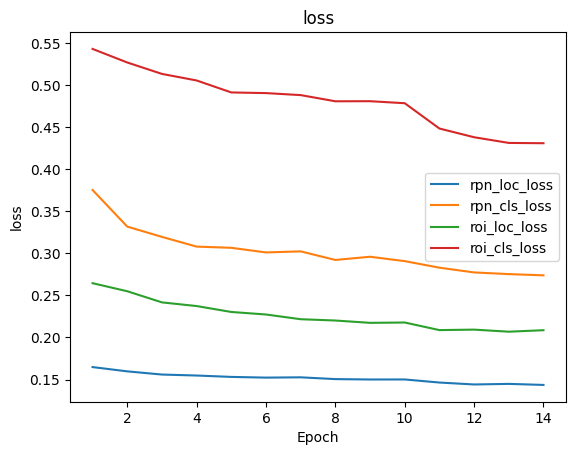

In [40]:
import matplotlib.pyplot as plt
plt.plot(x, rpn_loc_losses, label='rpn_loc_loss')
plt.plot(x, rpn_cls_losses, label='rpn_cls_loss')
plt.plot(x, roi_loc_losses, label='roi_loc_loss')
plt.plot(x, roi_cls_losses, label='roi_cls_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend()

plt.show()

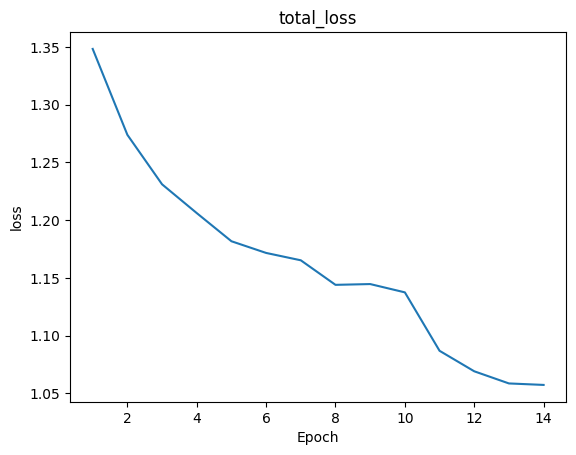

In [41]:
plt.plot(x,total_losses)
plt.title('total_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')


plt.show()

### Inference

In [42]:
def eval(dataloader, faster_rcnn):
    outputs = []
    for ii, (imgs, sizes) in enumerate(tqdm(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        for out in range(len(pred_bboxes_)):
            outputs.append({'boxes':pred_bboxes_[out], 'scores': pred_scores_[out], 'labels': pred_labels_[out]})

    return outputs

In [43]:
def inference():

    # Test dataset 불러오기
#     testset = TestDataset()
    annotation = os.path.join(data_dir,'test.json')
    testset = TestCustom(annotation, data_dir)
    test_dataloader = data_.DataLoader(testset,
                                       batch_size=1, # only batch_size=1 support
                                       num_workers=0,
                                       shuffle=False,
                                       pin_memory=False
                                       )
    # faster rcnn 불러오기
    faster_rcnn = FasterRCNNVGG16().cuda()
    state_dict = torch.load(inf_load_path)
    if 'model' in state_dict:
        faster_rcnn.load_state_dict(state_dict['model'])
    print('load pretrained model from %s' % inf_load_path)

    # evaluation
    outputs = eval(test_dataloader, faster_rcnn)
    score_threshold = 0.05
    prediction_strings = []
    file_names = []

    # submission file 작성
    coco = COCO(os.path.join(data_dir, 'test.json'))
    for i, output in enumerate(outputs):
        prediction_string = ''
        image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score > score_threshold:
                prediction_string += str(label) + ' ' + str(score) + ' ' + str(box[1]) + ' ' + str(
                    box[0]) + ' ' + str(box[3]) + ' ' + str(box[2]) + ' '
        prediction_strings.append(prediction_string)
        file_names.append(image_info['file_name'])
    submission = pd.DataFrame()
    submission['PredictionString'] = prediction_strings
    submission['image_id'] = file_names
    submission.to_csv("./faster_rcnn_scratch_submission.csv", index=False)

    print(submission.head())

In [44]:
inference()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load pretrained model from ./checkpoints/faster_rcnn_scratch_checkpoints.pth


100%|██████████| 4871/4871 [05:59<00:00, 13.55it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
                                    PredictionString       image_id
0  0 0.50945866 233.79395 681.82666 302.74054 748...  test/0000.jpg
1  0 0.21954826 129.16481 0.0 505.90497 298.2909 ...  test/0001.jpg
2  0 0.30004552 301.80237 46.330788 337.87445 180...  test/0002.jpg
3  0 0.18741061 74.61133 5.0803986 1024.0 324.306...  test/0003.jpg
4  0 0.6950482 177.56168 312.97095 802.1327 779.7...  test/0004.jpg


# Reference
https://github.com/chenyuntc/simple-faster-rcnn-pytorch \
https://github.com/shkim960520/faster-rcnn-for-studying